In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import sys
sys.path.append('../')

from utils import api_requests as req
from utils import funciones as func

# EDA

In [2]:
#Lo cargamos desde el fichero
df = pd.read_csv("../data/dataCardsclean.csv")
#Lo miramos para ver que está bonito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84896 entries, 0 to 84895
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 84896 non-null  object 
 1   cmc                  84896 non-null  float64
 2   oracle_text          84896 non-null  object 
 3   reserved             84896 non-null  bool   
 4   game_changer         84896 non-null  bool   
 5   foil                 84896 non-null  bool   
 6   nonfoil              84896 non-null  bool   
 7   promo                84896 non-null  bool   
 8   reprint              84896 non-null  bool   
 9   textless             84896 non-null  bool   
 10  full_art             84896 non-null  bool   
 11  booster              84896 non-null  bool   
 12  edhrec_rank          84896 non-null  float64
 13  released_year        84896 non-null  int64  
 14  Artifact             84896 non-null  int64  
 15  Battle               84896 non-null 

In [3]:
df.isnull().sum()

name                   0
cmc                    0
oracle_text            0
reserved               0
game_changer           0
foil                   0
nonfoil                0
promo                  0
reprint                0
textless               0
full_art               0
booster                0
edhrec_rank            0
released_year          0
Artifact               0
Battle                 0
Creature               0
Enchantment            0
Instant                0
Kindred                0
Land                   0
Legendary              0
Planeswalker           0
Snow                   0
Sorcery                0
World                  0
B                      0
G                      0
R                      0
U                      0
W                      0
legal_standard         0
legal_pioneer          0
legal_modern           0
legal_legacy           0
legal_vintage          0
legal_commander        0
legal_pauper           0
keyword_count          0
has_evasion            0


## 1. Análisis de final_price_eur (el target)

In [4]:
df['final_price_eur'].describe()

count    84896.000000
mean        13.198059
std        248.822669
min          0.010000
25%          0.120000
50%          0.310000
75%          1.560000
max      30194.400000
Name: final_price_eur, dtype: float64

Distribución altamente sesgada a la derecha. Esto significa que la mayoría de las cartas valen muy poco, pero hay algunas con precios extremadamente altos que elevan la media.

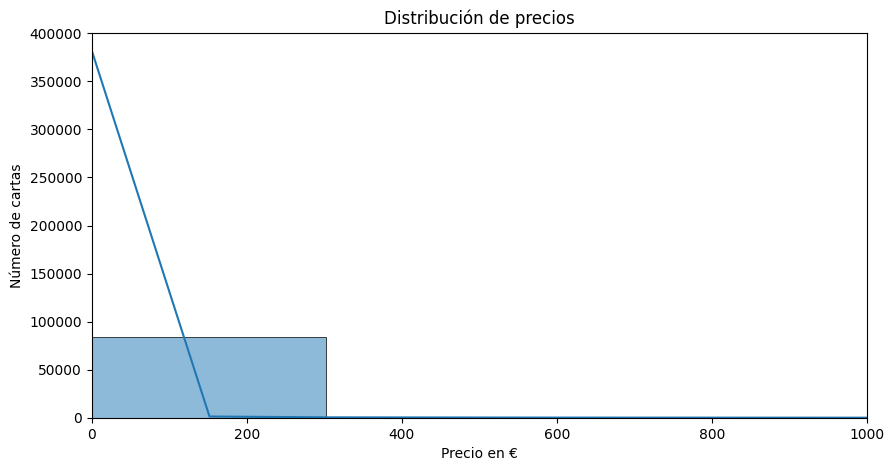

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df['final_price_eur'], bins=100, kde=True)
# sns.distplot(df["final_price_eur"], kde=True)
plt.title('Distribución de precios')
plt.xlabel('Precio en €')
plt.ylabel('Número de cartas')
plt.xlim(0, 1000)  
plt.show()

C:\Users\Edurne\AppData\Local\Temp\ipykernel_4176\2908404485.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["final_price_eur"])


<Axes: xlabel='final_price_eur', ylabel='Density'>

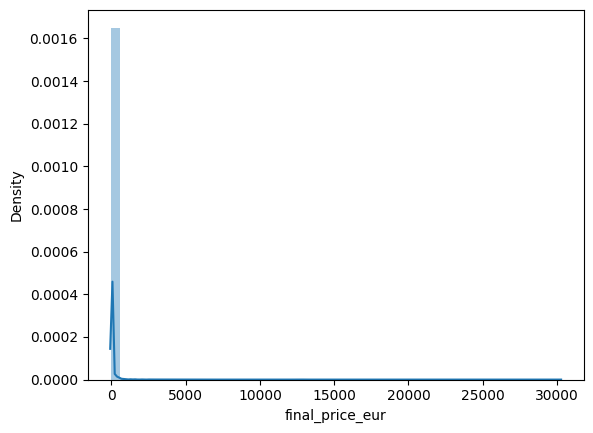

In [6]:
sns.distplot(df["final_price_eur"])

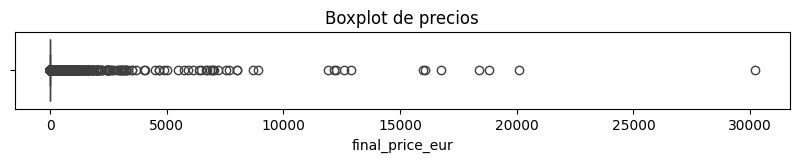

In [7]:
# detectar outliers

plt.figure(figsize=(10, 1))
sns.boxplot(x=df['final_price_eur'])
plt.title('Boxplot de precios')
plt.show()

In [8]:
(df['final_price_eur'] <= 0.5).mean()

0.5937028835280814

59.1% tiene precios muy bajos.

Le vamos a aplicar una transformación logarítmica y probablemente eliminemos los outliers.

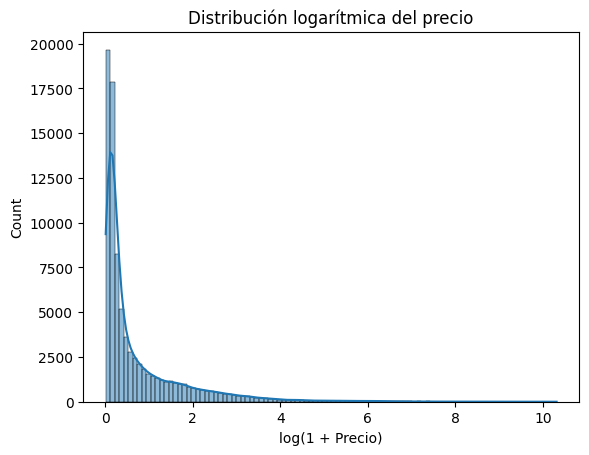

In [9]:
import numpy as np

# df['log_price'] = np.log1p(df['final_price_eur'])

sns.histplot(df['log_price'], bins=100, kde=True)
plt.title('Distribución logarítmica del precio')
plt.xlabel('log(1 + Precio)')
plt.show()

Posibles puntos de corte

In [10]:
target = 'log_price'
df_target = df[df[target].notna()]  # descarta NaNs para los cálculos

# 1. IQR
Q1 = df_target[target].quantile(0.25)
Q3 = df_target[target].quantile(0.75)
IQR = Q3 - Q1
iqr_cutoff = Q3 + 1.5 * IQR

# 2. Percentil 99.5
p995_cutoff = df_target[target].quantile(0.995)

# 3. Corte práctico (por ejemplo, > 10 €)
practical_cutoff = 4

# Calcula número y porcentaje para cada umbral
total = len(df_target)

def outlier_stats(cutoff, label):
    count = (df_target[target] > cutoff).sum()
    pct = count / total
    return {'Método': label, 'Corte log': round(cutoff, 2), 'Nº cartas': count, 'Proporción': round(pct, 4)}

# Construir tabla
summary = pd.DataFrame([
    outlier_stats(iqr_cutoff, 'IQR (Q3 + 1.5*IQR)'),
    outlier_stats(p995_cutoff, 'Percentil 99.5'),
    outlier_stats(practical_cutoff, 'Corte práctico (>100€)')
])

print(summary)

                   Método  Corte log  Nº cartas  Proporción
0      IQR (Q3 + 1.5*IQR)       2.18       8147      0.0960
1          Percentil 99.5       5.96        425      0.0050
2  Corte práctico (>100€)       4.00       1738      0.0205


In [11]:
df[df["log_price"] >= 4]

,name,cmc,oracle_text,reserved,game_changer,foil,nonfoil,promo,reprint,textless,...,legal_commander,legal_pauper,keyword_count,has_evasion,mana_produced_count,power_num,toughness_num,rarity_labeled,final_price_eur,log_price
43,Shahrazad,2.0,"Players play a Magic subgame, using their libr...",True,False,False,True,False,False,False,...,-2,0,0,0,0,-2.0,-2.0,2,290.91,5.676446
80,Eldrazi Temple,0.0,{T}: Add {C}.\n{T}: Add {C}{C}. Spend this man...,False,False,True,True,False,True,False,...,1,0,0,0,1,-2.0,-2.0,2,80.71,4.403176
183,Cyclopean Tomb,4.0,"{2}, {T}: Put a mire counter on target non-Swa...",True,False,False,True,False,True,False,...,1,0,0,0,0,-2.0,-2.0,2,344.01,5.843573
197,Thorn of Amethyst,2.0,Noncreature spells cost {1} more to cast.,False,False,True,False,False,True,False,...,1,0,0,0,0,-2.0,-2.0,3,883.21,6.784695
245,"Ulamog, the Infinite Gyre",11.0,"When you cast this spell, destroy target perma...",False,False,True,False,False,True,False,...,1,0,2,0,0,10.0,10.0,3,82.82,4.428672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84697,"Muldrotha, the Gravetide",6.0,"During each of your turns, you may play a land...",False,False,True,False,False,True,False,...,1,0,0,0,0,6.0,6.0,3,55.68,4.037421
84711,Sword of Feast and Famine,3.0,Equipped creature gets +2/+2 and has protectio...,False,False,True,False,False,True,False,...,1,0,1,0,0,-2.0,-2.0,4,132.15,4.891476
84725,Underground Sea,0.0,({T}: Add {U} or {B}.),True,False,False,True,False,False,False,...,1,0,0,0,2,-2.0,-2.0,2,12176.67,9.407359
84737,The Great Henge,9.0,"This spell costs {X} less to cast, where X is ...",False,False,True,True,False,False,False,...,1,0,0,0,1,-2.0,-2.0,3,58.18,4.080584


In [12]:
## Me voy a quedar con el precio logaritmizado y voy a dividir en mayores de 4 y menos de 4

## Relaciones features con el target

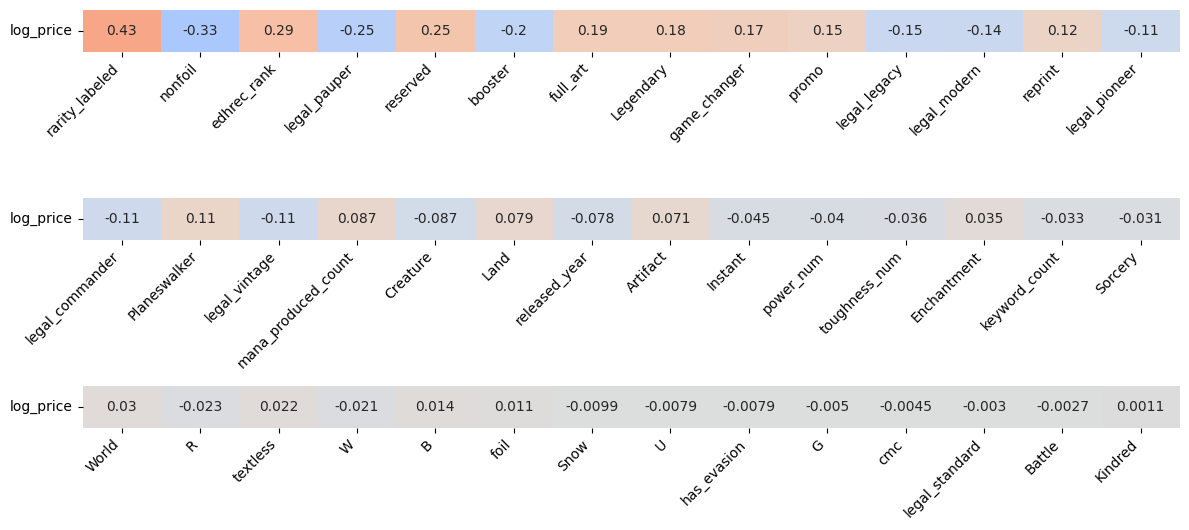

In [13]:
# Seleccionar columnas numéricas excepto el target
numerical_cols = df.select_dtypes(include=[np.number, np.bool_]).columns.tolist()
numerical_cols.remove('final_price_eur')
numerical_cols.remove('log_price')

# Calcular correlaciones con el target
corr_matrix = df[numerical_cols + ['log_price']].corr()
target_corr = corr_matrix.loc['log_price', numerical_cols]

# Ordenar por magnitud de correlación absoluta (opcional)
target_corr = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Partir en 3 bloques aproximadamente iguales
n_splits = 3
chunk_size = math.ceil(len(target_corr) / n_splits)
chunks = [target_corr[i:i + chunk_size] for i in range(0, len(target_corr), chunk_size)]

# Crear subplots
fig, axes = plt.subplots(nrows=n_splits, figsize=(12, 1.8 * n_splits))

for i, ax in enumerate(axes):
    sns.heatmap(chunks[i].to_frame().T, annot=True, cmap='coolwarm', center=0, vmin=-1, cbar=False, ax=ax)    
    ax.set_yticklabels(['log_price'], rotation=0)
    ax.set_xticklabels(chunks[i].index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

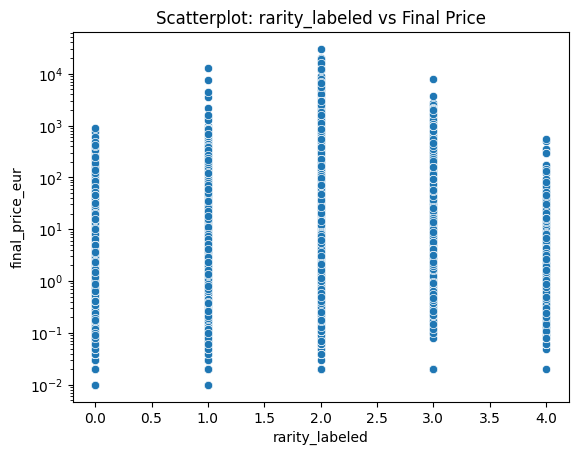

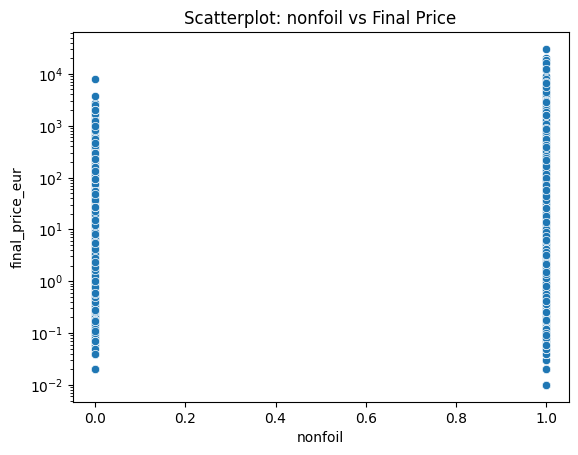

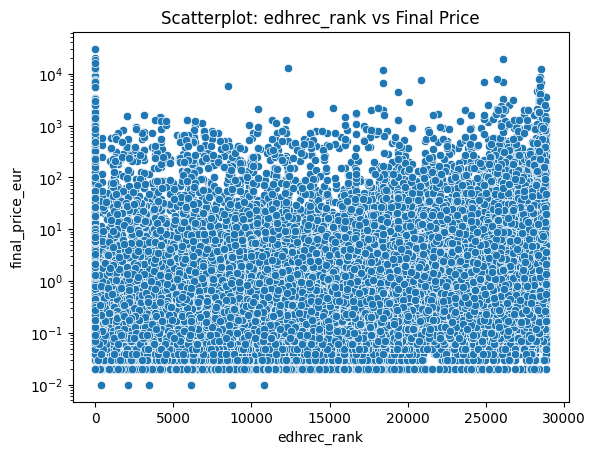

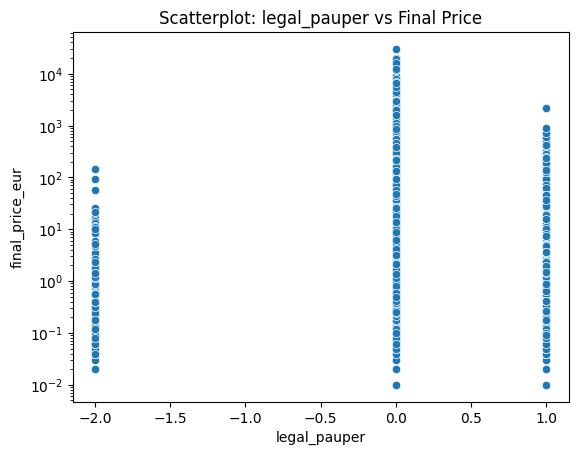

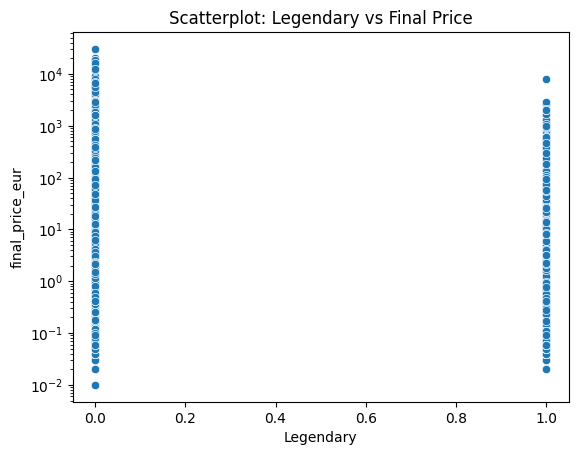

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

continuous_cols = ['rarity_labeled', 'nonfoil', 'edhrec_rank', 'legal_pauper',"Legendary"]  # puedes ajustar esta lista

for col in continuous_cols:
    sns.scatterplot(data=df, x=col, y='final_price_eur')
    plt.title(f'Scatterplot: {col} vs Final Price')
    plt.yscale('log')  # opcional, para comprimir valores extremos
    plt.show()

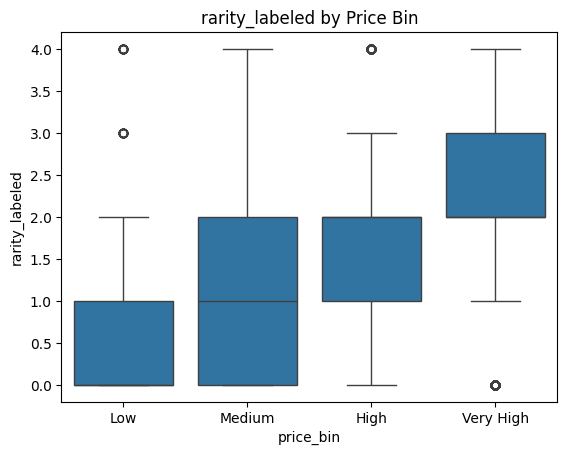

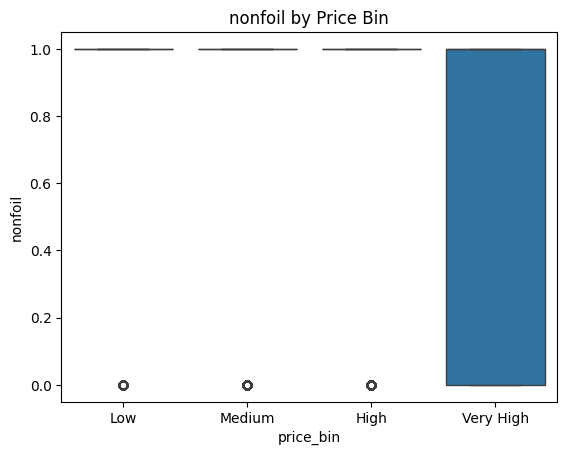

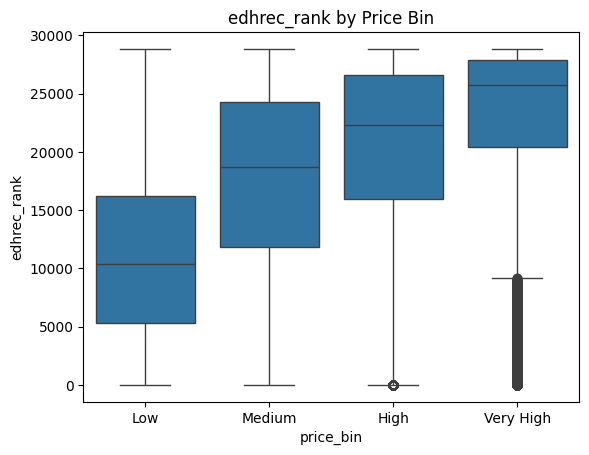

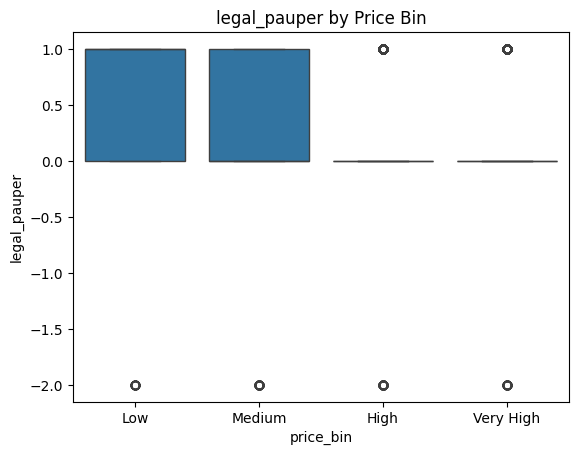

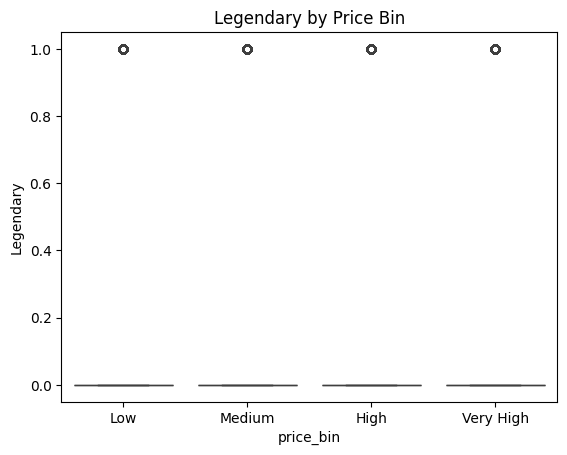

In [15]:
df['price_bin'] = pd.qcut(df['log_price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

for col in continuous_cols:
    sns.boxplot(data=df, x='price_bin', y=df[col])
    plt.title(f'{col} by Price Bin')
    plt.show()

In [16]:
# Se dividen en quartiles el precio, y se ve que en edhrec_rank y en rarity_lebel hay un incremento a medida que el crecen
# (de normal edhrec_rank cuanto más bajo mejor, pero recordar que lo cambié para que al final fuese al revés)
# Sin embargo, las cajas son gordas, varianza alta, puede depender de otros factores.
# EN los otros no parece haber mucha relación en un inicio.

In [17]:
from scipy.stats import spearmanr

lanzahombre = {}

for col in numerical_cols:
    coef, _ = spearmanr(df[col], df['final_price_eur'])
    lanzahombre[col] = coef.round(3)
df2 = pd.Series(lanzahombre).sort_values(ascending=False)

In [18]:
df2

rarity_labeled         0.641
edhrec_rank            0.500
Legendary              0.251
promo                  0.244
reprint                0.162
full_art               0.156
reserved               0.137
Planeswalker           0.128
mana_produced_count    0.124
game_changer           0.105
Land                   0.098
Artifact               0.071
released_year          0.065
Enchantment            0.055
B                      0.031
textless               0.030
World                  0.022
G                      0.021
U                      0.006
cmc                    0.005
Kindred                0.003
legal_standard         0.003
has_evasion            0.002
Battle                -0.001
Snow                  -0.003
W                     -0.010
legal_commander       -0.013
Sorcery               -0.013
R                     -0.014
legal_vintage         -0.031
foil                  -0.037
legal_legacy          -0.037
keyword_count         -0.052
toughness_num         -0.064
Instant       

Estas tienen más o menos una correlación creciente monotónica   

rarity_labeled         0.641  
edhrec_rank            0.500  
Legendary              0.251  
promo                  0.244  
reprint                0.162  
full_art               0.156  
reserved               0.137  
Planeswalker           0.128  

Y estas una correlación decreciente monotónica  

Creature              -0.106  
legal_pioneer         -0.134  
legal_modern          -0.164  
nonfoil               -0.366  
booster               -0.380  
legal_pauper          -0.445  

QUe no sé muy bien como interpretar esas últimas. Pauper tiene sentido, porque es un formato en la que sólo se pueden jugar cartas baratas. Nonfoil raro, porque si es foil debería ser más cara. No sé si estoy entendiendo bien la relación. Ah vale, que tiene sentido, ahora recuerdo lo que significa nonfoil. Nonfoil es que esa carta no tiene versión foil, creo.

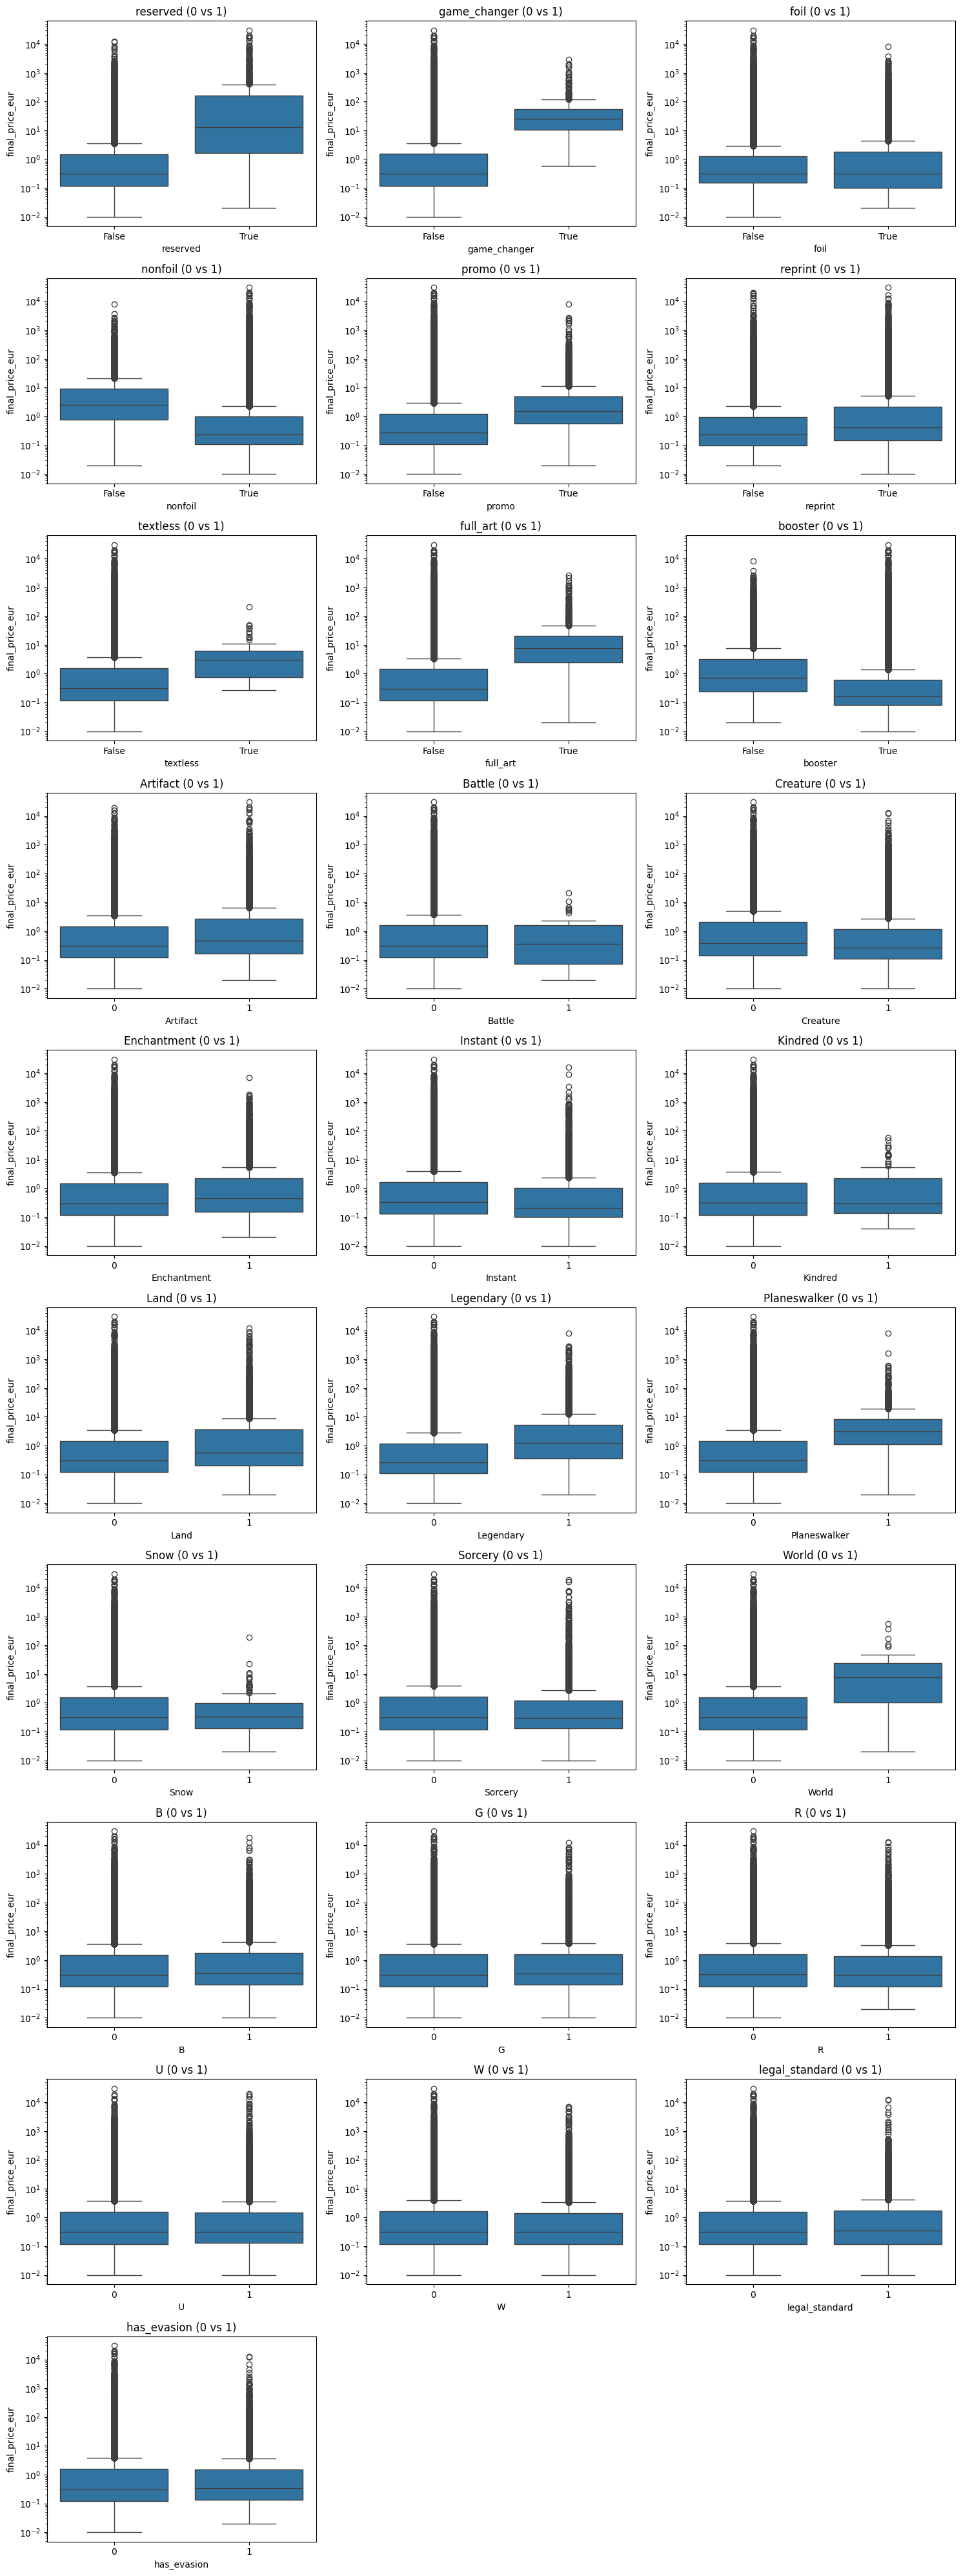

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener columnas booleanas (numéricas con sólo 2 valores distintos)
# bool_cols = [col for col in df.select_dtypes(include=['int64', 'int32', 'float64']).columns 
#              if df[col].nunique() == 2 and col != 'final_price_eur']
bool_cols = [col for col in numerical_cols if df[col].nunique() == 2]

# Crear una grid de subplots
n_cols = 3
n_rows = (len(bool_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

# Flatten axes para iterar fácilmente
axes = axes.flatten()

# Crear boxplots para cada columna booleana
for i, col in enumerate(bool_cols):
    sns.boxplot(data=df, x=col, y='final_price_eur', ax=axes[i])
    axes[i].set_title(f'{col} (0 vs 1)')
    axes[i].set_yscale('log')

# Eliminar subplots vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [20]:
## Lo que entiendo o veo. Por o general los planeswalker o los legendarios tienden a ser más caros. Lo mismo si son fullart
## lo cual tiene sentido. Lo mismo con reserved y game_changers. Tiene sentido. Parece que vamos por buen camino.

## Distribución de las Features

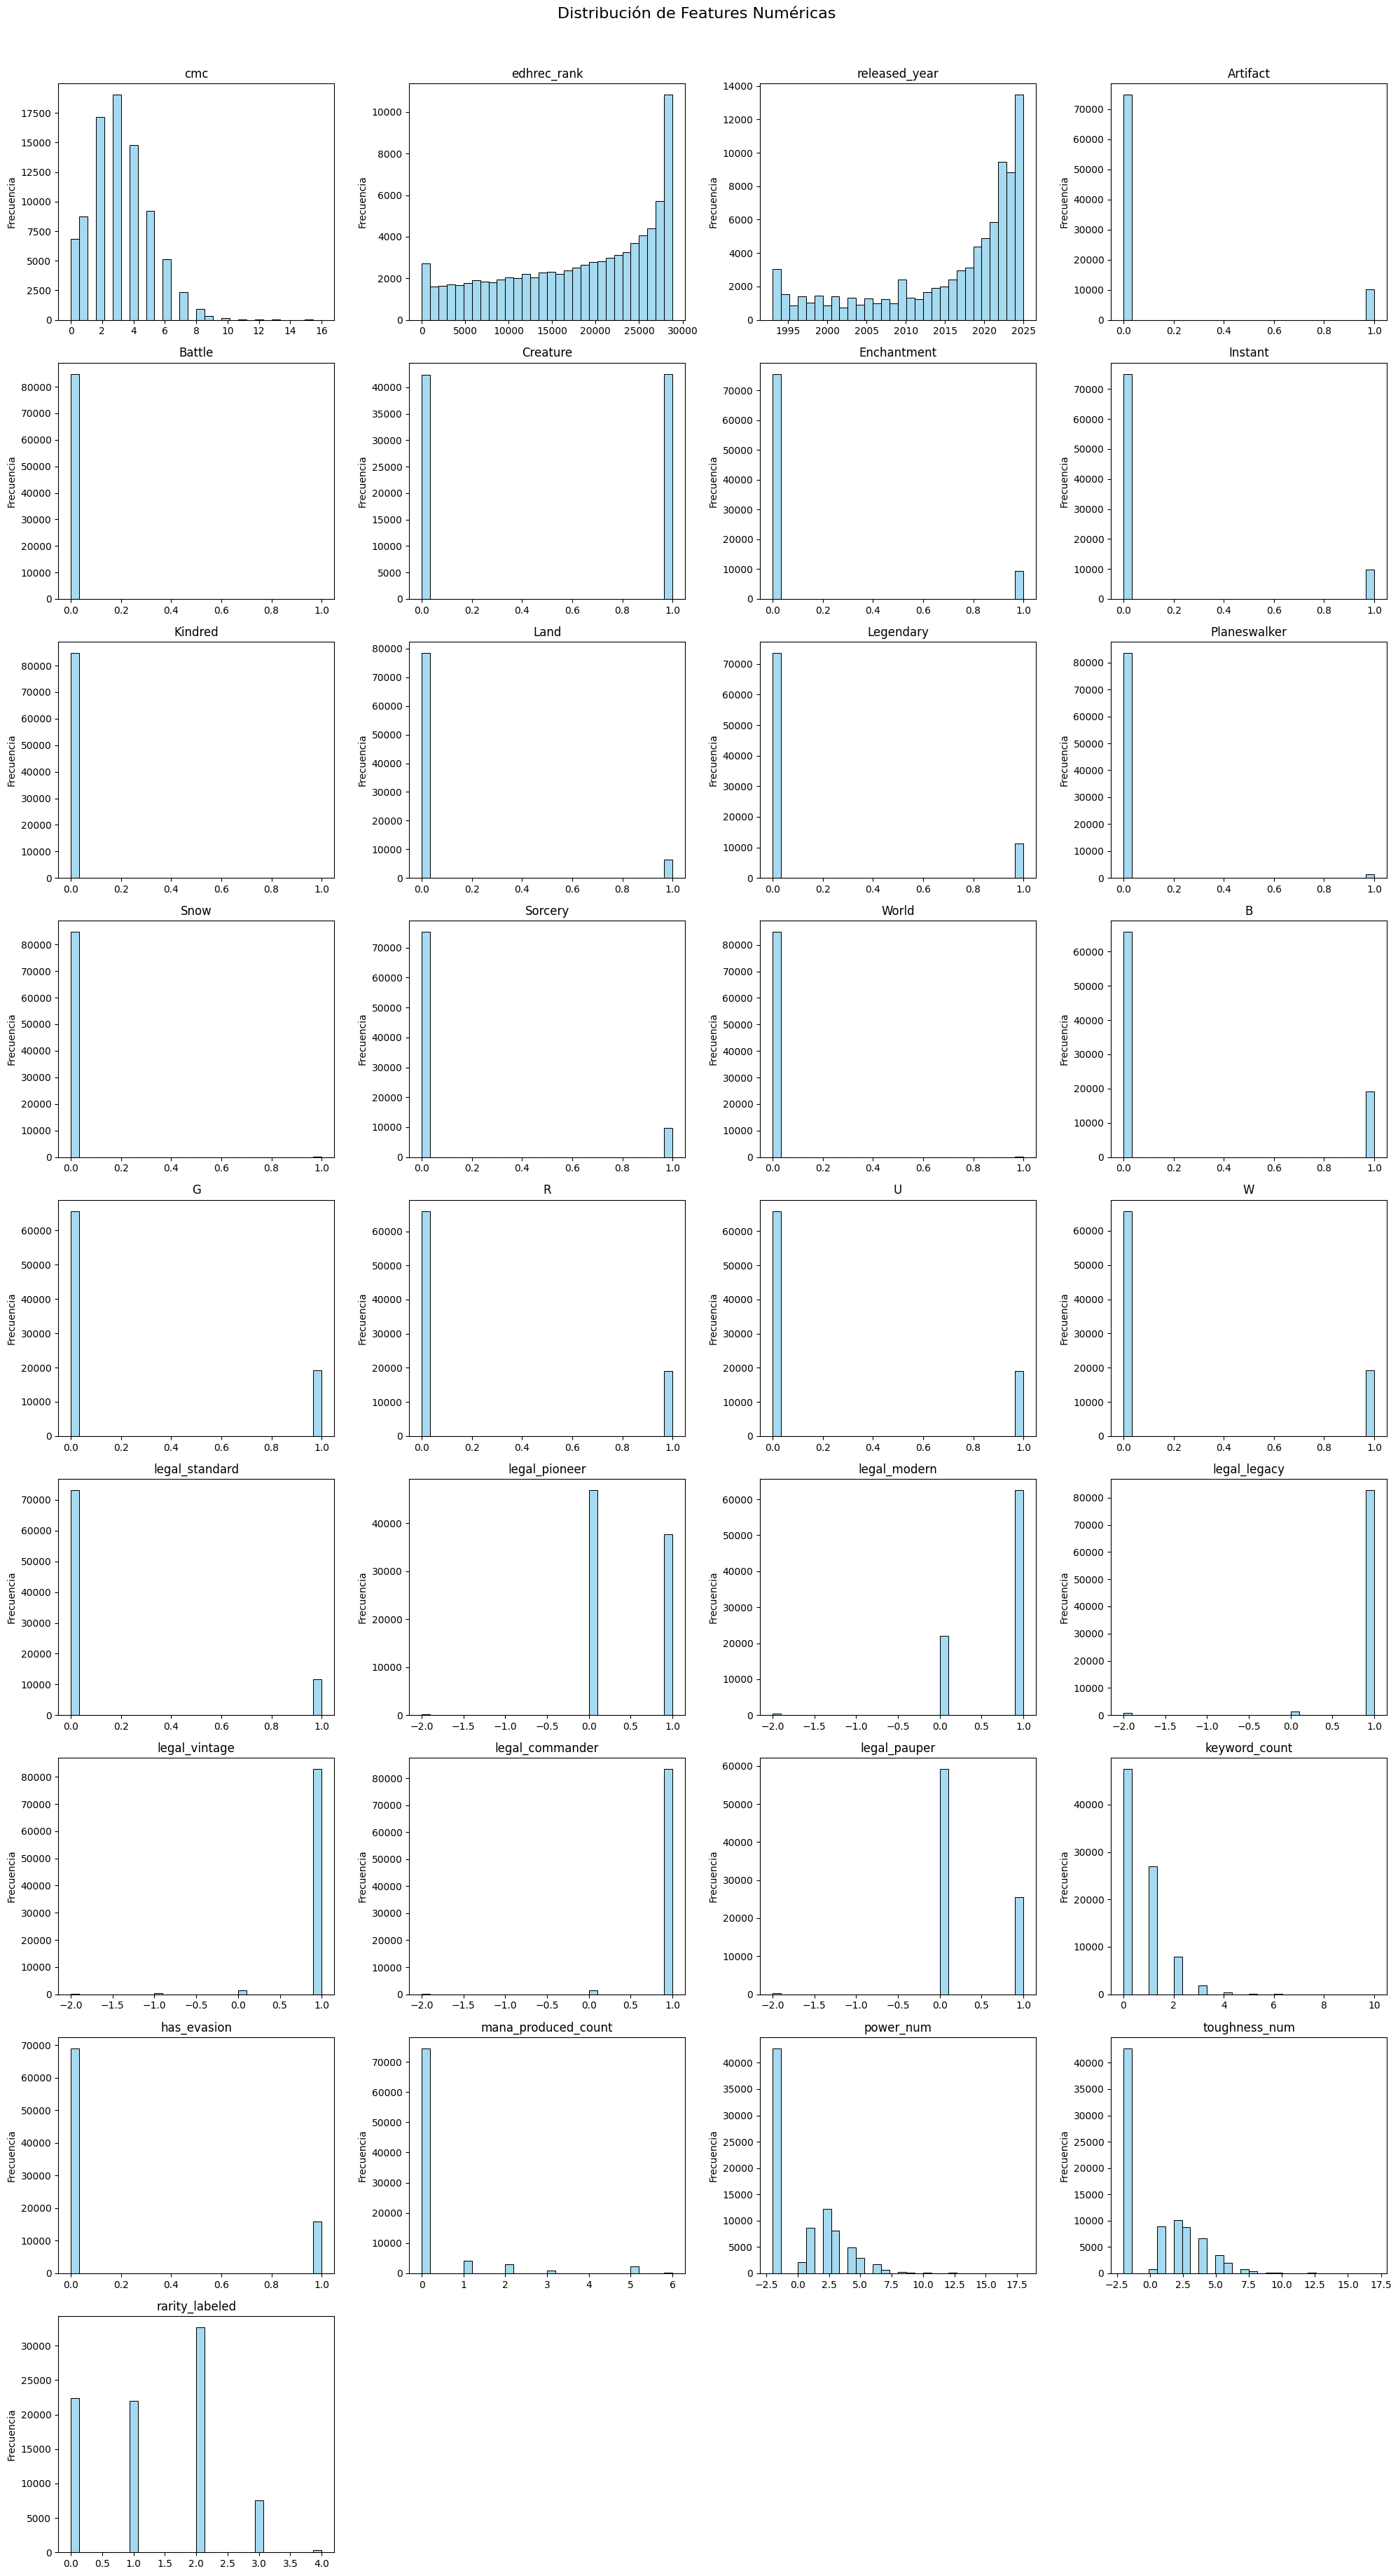

In [24]:
# Seleccionamos columnas numéricas (sin incluir el target)
numeric_cols = df.select_dtypes(include=["int64", "float64", "int32"]).columns.tolist()
numeric_cols.remove("final_price_eur")
numeric_cols.remove("log_price")

# Número de columnas por fila en la matriz
cols_per_row = 4
n_cols = len(numeric_cols)
n_rows = (n_cols + cols_per_row - 1) // cols_per_row

# Crear subplots
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), ax=axes[i], kde=False, bins=30, color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

# Ocultar subgráficos vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
fig.suptitle('Distribución de Features Numéricas', fontsize=16, y=1.02)
plt.show()


In [ ]:
## Voy a tener que escalar, igual un minmax o así



## Análisis features binarias

In [ ]:
# Seleccionar columnas booleanas o binarias (0/1)
bool_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype in ['bool', 'int64', 'int32']]

# Crear resumen
summary = []

for col in bool_cols:
    group_means = df.groupby(col)["final_price_eur"].mean()
    group_counts = df[col].value_counts(normalize=True)

    summary.append({
        "Feature": col,
        "Mean if 0": group_means.get(0, float('nan')),
        "Mean if 1": group_means.get(1, float('nan')),
        "Ratio of 1s": group_counts.get(1, 0),
        "Ratio of 0s": group_counts.get(0, 0),
        "Delta (1 - 0)": group_means.get(1, 0) - group_means.get(0, 0)
    })

# Convertir a DataFrame
bool_summary_df = pd.DataFrame(summary)
bool_summary_df.sort_values(by="Delta (1 - 0)", ascending=False, inplace=True)

# Mostrar
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# print(bool_summary_df)

C:\Users\Edurne\AppData\Local\Temp\ipykernel_1012\5412450.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Mean if 0": group_means.get(0, float('nan')),
C:\Users\Edurne\AppData\Local\Temp\ipykernel_1012\5412450.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Mean if 1": group_means.get(1, float('nan')),
C:\Users\Edurne\AppData\Local\Temp\ipykernel_1012\5412450.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Ratio of

C:\Users\Edurne\AppData\Local\Temp\ipykernel_1012\2202654055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bool_summary_df, x="Delta (1 - 0)", y="Feature", palette="coolwarm")


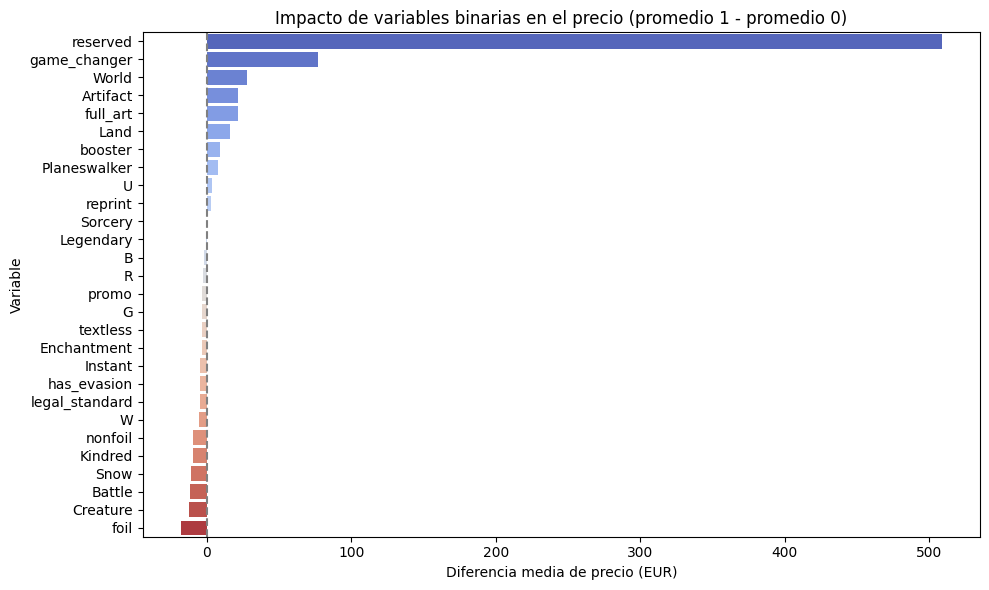

In [ ]:
# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=bool_summary_df, x="Delta (1 - 0)", y="Feature", palette="coolwarm")
plt.title("Impacto de variables binarias en el precio (promedio 1 - promedio 0)")
plt.xlabel("Diferencia media de precio (EUR)")
plt.ylabel("Variable")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## Matriz de Correlación

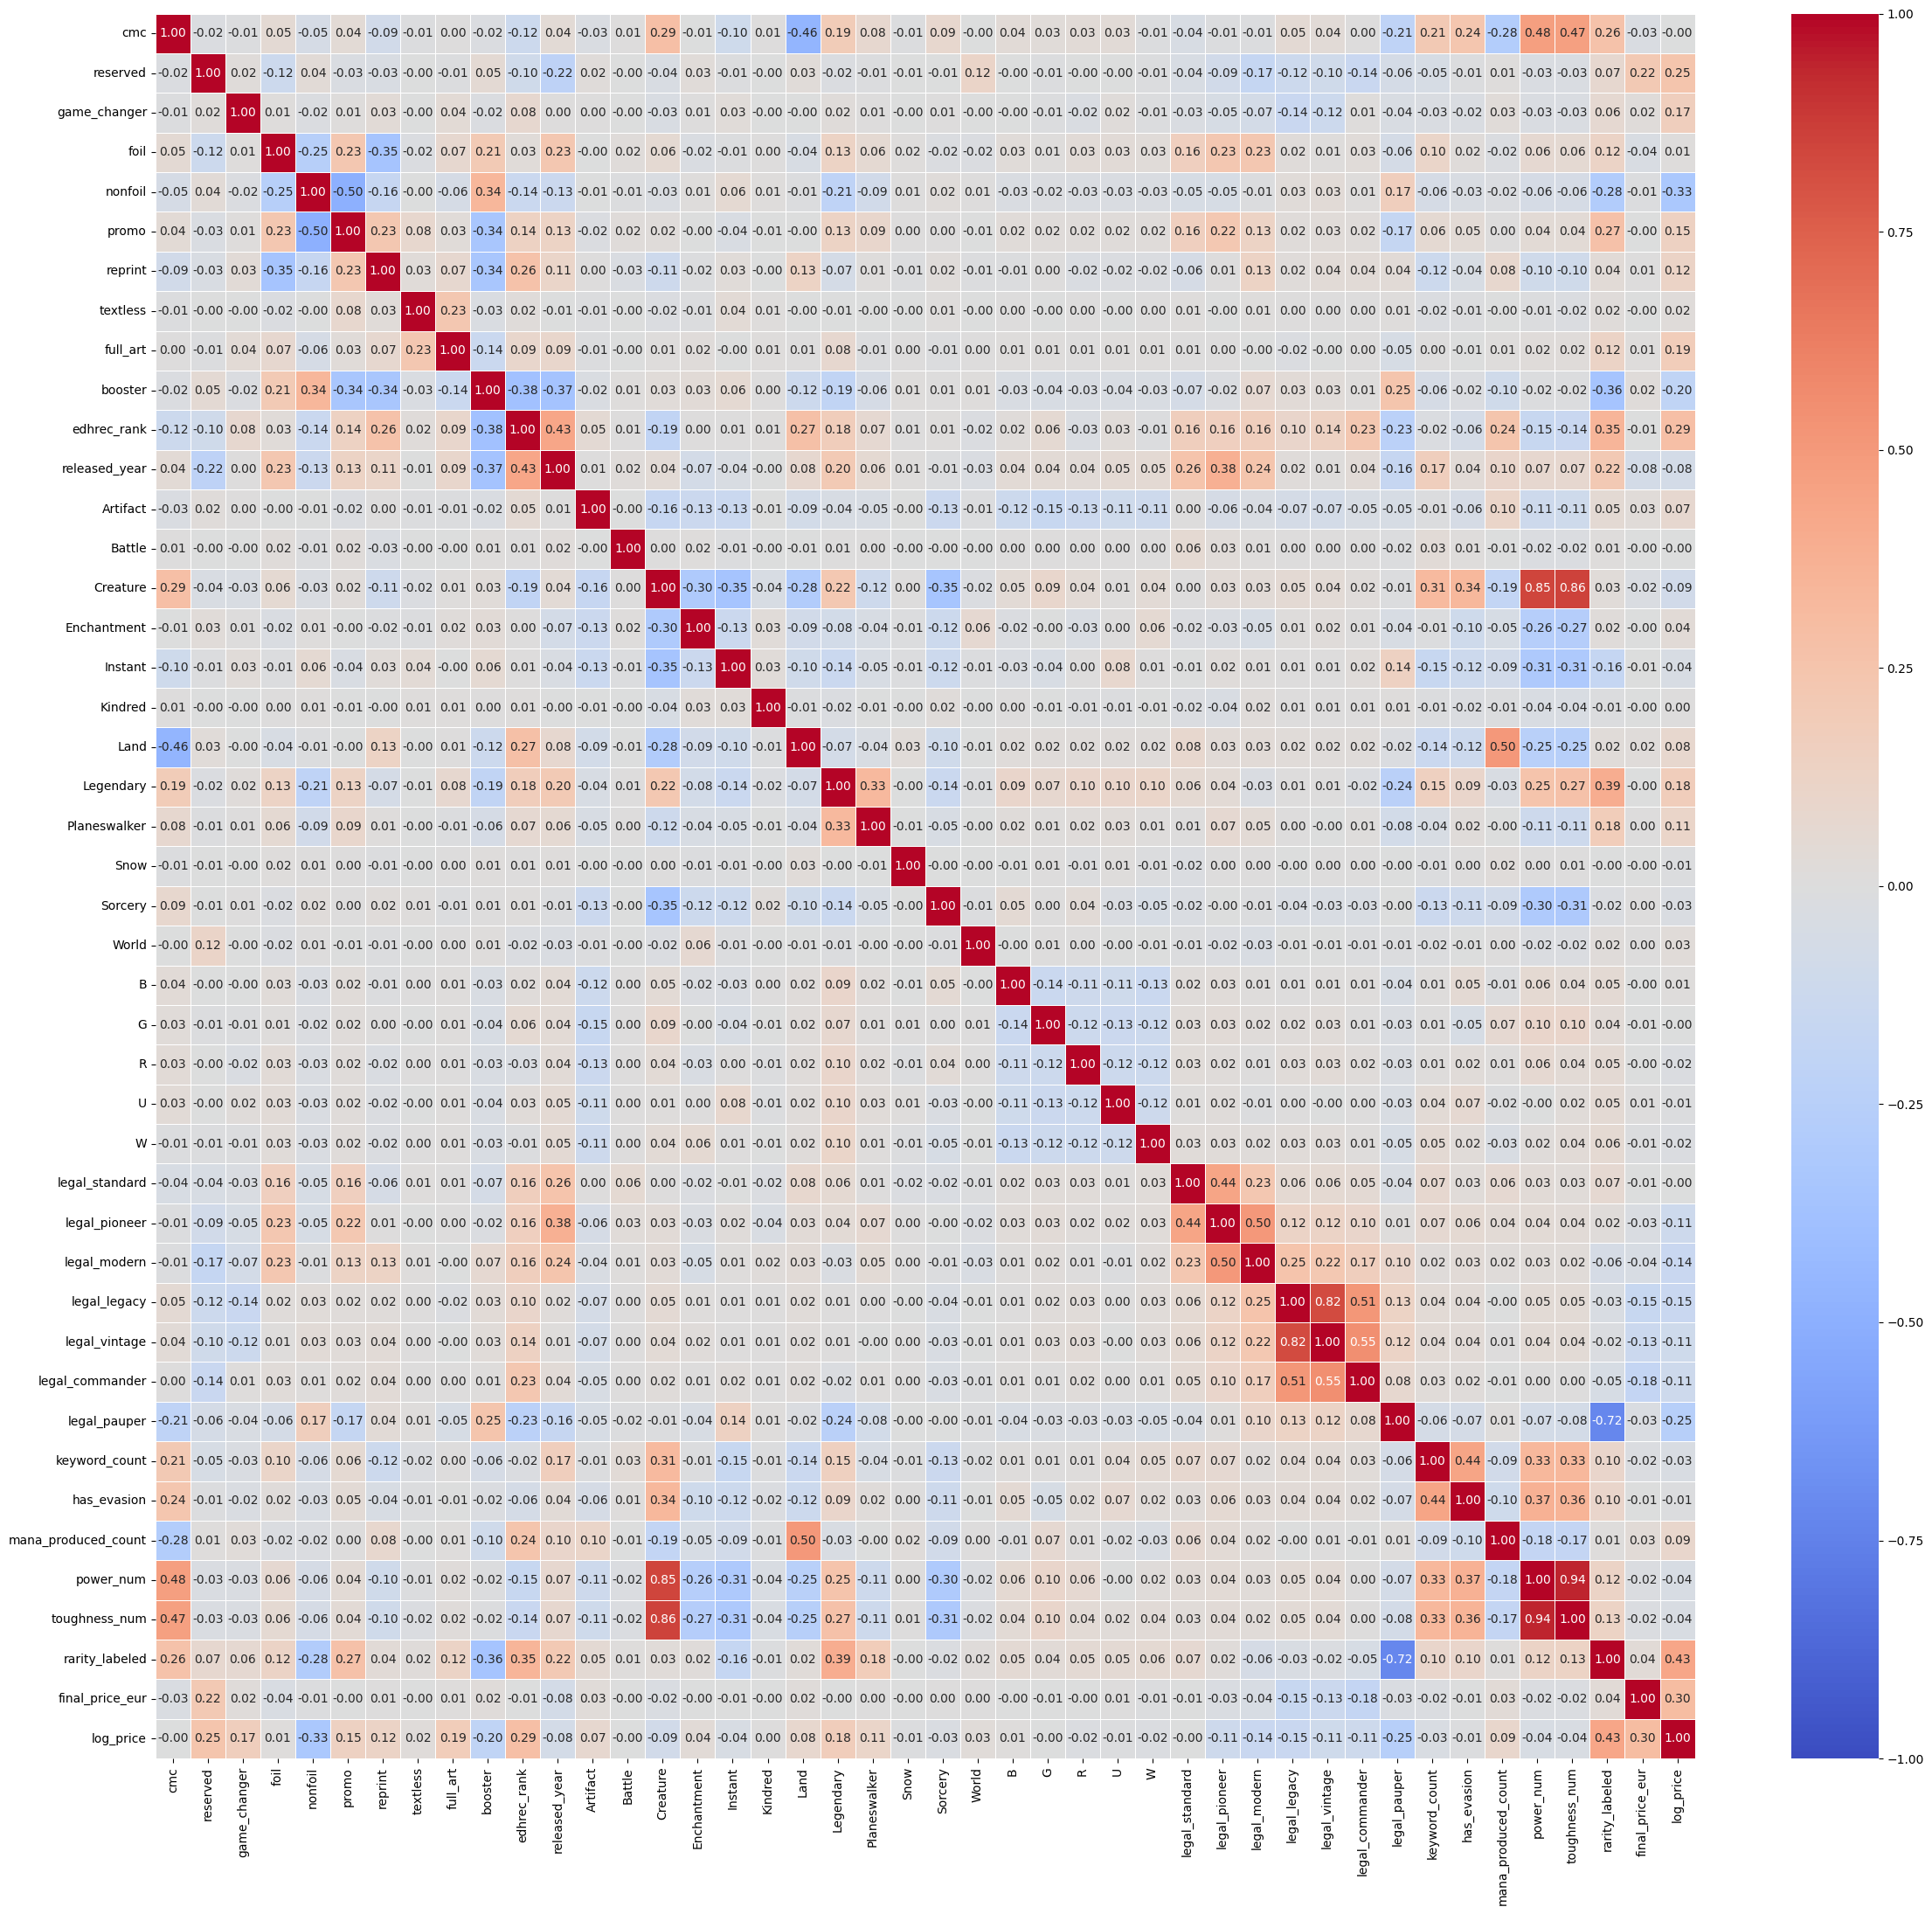

In [ ]:
# Matriz de correlación solo con variables numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])
corr_matrix = numeric_df.corr()

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(24, 22))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, center=0, vmin=-1)
plt.tight_layout()
plt.show()